## Das beste Modell: 
### Logistic Regression, Tfidf, Trigramme and Max. Feature = 100000
Nach der Modellauswertung ist es festgestellt, welches Modell mit welchen Merkmalen ausgewählt werden muss. Für die Vorhersage dieser Fallstudie wird die logistische Regression verwendet. Dazu wird die TF-IDF-Methode mit Trigrammen und maximaler Anzahl von Features von 100000 genutzt. Außerdem kann das beste Ergebnis mit einem Datensatz, der Stoppwörter noch enthält, erzielt werden. Daher wird die Datei 'clean_tweet.csv' verwendet.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv)
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)

In [2]:
SEED = 26105111
# Trainingsdaten und Testdaten werden aufgesplittet
x = my_df.text
y = my_df.sentiment
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.05, random_state=SEED)

# TF-IDF wird zur Merkmalenextraktion ausgewählt
tvec = TfidfVectorizer(ngram_range=(1, 3),max_features=100000)
tvec.fit(x_train)
x_train = tvec.transform(x_train)
x_test = tvec.transform(x_test)

# logisitsche Regression wird für die Vorhersage ausgewählt
lr_model = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
fit = lr_model.fit(x_train, y_train)
y_pred = fit.predict(x_test)

# Klassifizierungswerte
print(lr_model)
print("Accuracy: {0:.2f}%".format(accuracy_score(y_test, y_pred)*100))
print("-"*80)
print("Classification Report\n")
print(classification_report(y_test, y_pred, digits=4))

LogisticRegression(C=2, max_iter=1000, n_jobs=-1)
Accuracy: 82.41%
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

           0     0.8322    0.8122    0.8221     39951
           1     0.8163    0.8360    0.8260     39877

    accuracy                         0.8241     79828
   macro avg     0.8243    0.8241    0.8240     79828
weighted avg     0.8243    0.8241    0.8240     79828



## Fallstudie: 
Zur Untersuchung wird ein Datensatz ausgewählt, der während eines wichtigen Ereignisses, der US-Präsidentschaftswahl im Jahr 2020, gesammelt wurde. Die Analyse der Stimmungslage der Menschen, die auf die Wahl reagieren, wird Aufschluss darüber geben, ob es während des Ereignisses möglicherweise zu Straftaten im Zusammenhang mit der Cybersicherheit kommt, die sich gegen die Kandidaten oder die Regierung richten.

### 1. Untersuchung des Nutzersentiments gegenüber Kandidat 1:

In [3]:
data = pd.read_csv("hashtag_donaldtrump.csv",encoding = "ISO-8859-1", lineterminator='\n')
df = data.iloc[:,[0,2,8,15,16]]
df = df.rename(columns={'tweet':'text'})
df.head()

,created_at,text,user_screen_name,city,country
0,2020-10-15 00:00:01,#Elecciones2020 | En #Florida: #JoeBiden dice ...,elsollatinonews,NaN,United States of America
1,2020-10-15 00:00:01,"Usa 2020, Trump contro Facebook e Twitter: cop...",MediasetTgcom24,NaN,NaN
2,2020-10-15 00:00:02,"#Trump: As a student I used to hear for years,...",snarke,Portland,United States of America
3,2020-10-15 00:00:02,2 hours since last tweet from #Trump! Maybe he...,trumpytweeter,NaN,NaN
4,2020-10-15 00:00:08,You get a tie! And you get a tie! #Trump âs ...,Ranaabtar,Washington,United States of America


### 1.1 Filtern nach IT-Sicherheit-bezogenen Termen
gemäß ”The Glossary of Common Cybersecurity Terminology”
(Quelle:https://niccs.cisa.gov/about-niccs/cybersecurity-glossary)

In [4]:
# Tokenisierung: Texte wird in einzelne Wörter zerlegt
text = df.text.str.split('\s+')

# Liste ausgewählter IT-sicherheit-relevanten Termen
cs_termen = set(["phishing","dos","botnet", "hacker","xss","wannacry", 
                 "heartbled", "DDoS", "ransomware", "malware","mitm", 
                 "petya", "mirai", "firewall", "trojan", "worm", "bot", 
                 "stuxnet","eternalblue", "infosec", "keylogger", "spam", 
                 "spammer", "rootkit", "phreaking", "conficker", "worm", "scam", "hack"])

# Der Filter wird definiert
def cs_filter(termen):
    return any(term in cs_termen for term in termen)

# Filter wird auf den Datensatz verwendet
gefilterte_text = text.apply(cs_filter)
my_df = df[gefilterte_text]
print(str(len(my_df)) + ' Twitter-Texte mit IT-Sicherheit Termen werden gefunden')

2330 Twitter-Texte mit IT-Sicherheit Termen werden gefunden


In [5]:
my_df= pd.DataFrame(my_df[gefilterte_text])
my_df = my_df.reset_index(drop=True)

<ipython-input-5-d67921a4f70f>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  my_df= pd.DataFrame(my_df[gefilterte_text])


### 1.2 Datenverarbeitung

In [6]:
# notwendige Python-Pakete importieren
import pandas as pd
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer

con_dict = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", 
            "weren't":"were not","haven't":"have not","hasn't":"has not",
            "hadn't":"had not","won't":"will not","wouldn't":"would not",
            "don't":"do not", "doesn't":"does not","didn't":"did not",
            "can't":"can not","couldn't":"could not","shouldn't":"should not",
            "mightn't":"might not","mustn't":"must not", "'s":" is", "'re":" are", 
            "'m":" am", "'ll":" will", "'d":" would"}

con_re = re.compile('(%s)' % '|'.join(con_dict.keys()))
tok = WordPunctTokenizer()

# Vorverarbeitungsschritte, die unternommen werden sollen, sind z.B. Trennung der zusammengezogenen Wörter,
# Entfernung von Sonderzeichen und Zahlen, HTML-Umwandlung, Kleinschreibung
def dvv(text):    
    wort_trennen = con_re.sub(lambda x: con_dict[x.group()],str(text))
    url_entfernen = re.sub('((www.[^ ]+)|(https?://[^ ]+))','',wort_trennen)
    soup = BeautifulSoup(url_entfernen, 'lxml')
    souped = soup.get_text()
    klein_umwandeln = str(souped).lower()
    zahlen_entfern = re.sub(r'((@[A-Za-z0-9_]+)|([0-9]+)|([&?.!/;:%*+-<>§$]))', " ", klein_umwandeln)
    wort = [x for x  in tok.tokenize(zahlen_entfern) if len(x) > 1]
    return (" ".join(wort)).strip()

# Alle Texte im Datensatz werden verarbeitet...
dvv_text = []
for i in range(0,len(my_df)):
    dvv_text.append(dvv(my_df['text'][i]))
print('Daten sind fertig verarbeitet')

#...und zusammenfassen
new_data = pd.DataFrame(dvv_text,columns=['text'])
new_data.text.dropna(inplace=True)

Daten sind fertig verarbeitet


### 1.3 Sentimentanalyse:

In [8]:
new_text = new_data.text
X_mat_1 = tvec.transform(new_text)
y_hat_1 = lr_model.predict(X_mat_1)

In [10]:
# neu klassifizierte Daten können angeschaut werden
predict = pd.DataFrame(my_df.text)
predict['sentiment'] = y_hat_1
predict['datum'] = my_df.created_at
predict['user_name'] = my_df.user_screen_name
predict['standort'] = my_df.city
predict.head()

,text,sentiment,datum,user_name,standort
0,Another #Murdoch hack job - just like @FoxNews...,1,2020-10-15 00:18:07,dtcav,Philadelphia
1,Lumumba is perplexed &amp; confused on an issu...,0,2020-10-15 00:33:27,KareemLumumba,NaN
2,Faltando 20 dias para as eleiÃ§Ãµes dos Estado...,0,2020-10-15 01:52:54,Eua2020,NaN
3,Biden and Obama are the most corrupt administr...,0,2020-10-15 01:57:29,Bit_Fink,NaN
4,What an ignorant and confused fool. #trump is ...,0,2020-10-15 03:22:45,JacklegBuster,NaN


In [11]:
# die Verteilung der Sentiment
predict["sentiment"].value_counts()

1    1519
0     811
Name: sentiment, dtype: int64

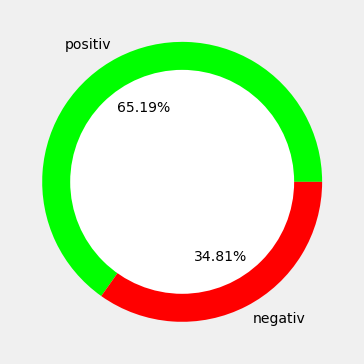

In [12]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.figure(figsize=(6, 6))
plt.pie(
    predict["sentiment"].value_counts(),
    autopct = "%.2f%%",
    labels = ["positiv", "negativ"],
    colors = ["#00ff00", "#ff0000"]
)

circle = plt.Circle((0,0), 0.80,fc='white')
fig = plt.gcf()
fig.gca().add_artist(circle)

plt.show()

In [13]:
text_negative_org = predict[predict["sentiment"]==0]
user = text_negative_org['user_name'].value_counts().nlargest(7)
pd.DataFrame(user)

,user_name
KempBadforGA,9
TelemundoNews,6
_bubblegyu,5
JacklegBuster,5
wollf_f_Crypto,4
marcelinharosa,4
Mundo__News,4


### 2. Untersuchung des Nutzersentiments gegenüber Kandidat 2:

In [14]:
data = pd.read_csv("hashtag_joebiden.csv",encoding = "ISO-8859-1", lineterminator='\n')
df = data.iloc[:,[0,2,8,15,16]]
df = df.rename(columns={'tweet':'text'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776886 entries, 0 to 776885
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   created_at        776886 non-null  object
 1   text              776886 non-null  object
 2   user_screen_name  776886 non-null  object
 3   city              186872 non-null  object
 4   country           353779 non-null  object
dtypes: object(5)
memory usage: 29.6+ MB


### 2.1 Filtern nach IT-Sicherheit-bezogenen Termen:
gemäß ”The Glossary of Common Cybersecurity Terminology”
(Quelle :https://niccs.cisa.gov/about-niccs/cybersecurity-glossary)

In [15]:
# Tokenisierung: Texte wird in einzelne Wörter zerlegt
text = df.text.str.split('\s+')

# Liste ausgewählter IT-sicherheit-relevanten Termen
cs_termen = set(["phishing","dos","botnet", "hacker","xss","wannacry", 
                 "heartbled", "DDoS", "ransomware", "malware","mitm", 
                 "petya", "mirai", "firewall", "trojan", "worm", "bot", 
                 "stuxnet","eternalblue", "infosec", "keylogger", "spam", 
                 "spammer", "rootkit", "phreaking", "conficker", "worm", "scam", "hack"])

# Der Filter wird definiert
def cs_filter(termen):
    return any(term in cs_termen for term in termen)

# Filter wird auf den Datensatz verwendet
gefilterte_text = text.apply(cs_filter)
my_df = df[gefilterte_text]
print(str(len(my_df)) + ' Twitter-Texte mit IT-Sicherheit Termen werden gefunden')

2010 Twitter-Texte mit IT-Sicherheit Termen werden gefunden


In [16]:
my_df= pd.DataFrame(my_df[gefilterte_text])
my_df = my_df.reset_index(drop=True)

<ipython-input-16-d67921a4f70f>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  my_df= pd.DataFrame(my_df[gefilterte_text])


### 2.2 Datenvorverarbeitung:

In [17]:
# notwendige Python-Pakete importieren
import pandas as pd
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer

con_dict = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", 
            "weren't":"were not","haven't":"have not","hasn't":"has not",
            "hadn't":"had not","won't":"will not","wouldn't":"would not",
            "don't":"do not", "doesn't":"does not","didn't":"did not",
            "can't":"can not","couldn't":"could not","shouldn't":"should not",
            "mightn't":"might not","mustn't":"must not", "'s":" is", "'re":" are", 
            "'m":" am", "'ll":" will", "'d":" would"}

con_re = re.compile('(%s)' % '|'.join(con_dict.keys()))
tok = WordPunctTokenizer()

# Vorverarbeitungsschritte, die unternommen werden sollen, sind z.B. Trennung der zusammengezogenen Wörter,
# Entfernung von Sonderzeichen und Zahlen, HTML-Umwandlung, Kleinschreibung
def dvv(text):    
    wort_trennen = con_re.sub(lambda x: con_dict[x.group()],str(text))
    url_entfernen = re.sub('((www.[^ ]+)|(https?://[^ ]+))','',wort_trennen)
    soup = BeautifulSoup(url_entfernen, 'lxml')
    souped = soup.get_text()
    klein_umwandeln = str(souped).lower()
    zahlen_entfern = re.sub(r'((@[A-Za-z0-9_]+)|([0-9]+)|([&?.!/;:%*+-<>§$]))', " ", klein_umwandeln)
    wort = [x for x  in tok.tokenize(zahlen_entfern) if len(x) > 1]
    return (" ".join(wort)).strip()

# Alle Texte im Datensatz werden verarbeitet...
dvv_text = []
for i in range(0,len(my_df)):
    dvv_text.append(dvv(my_df['text'][i]))
print('Daten sind fertig verarbeitet')

#...und als eine .csv-Datei abgespeichert
new_data = pd.DataFrame(dvv_text,columns=['text'])
new_data.text.dropna(inplace=True)

Daten sind fertig verarbeitet


### 2.3 Sentimentklassifizierung:

In [18]:
new_text = new_data.text
X_mat_2 = tvec.transform(new_text)
y_hat_2 = lr_model.predict(X_mat_2)

# neu klassifizierte Daten können angeschaut werden
predict = pd.DataFrame(my_df.text)
predict['sentiment'] = y_hat_2
predict['datum'] = my_df.created_at
predict['user_name'] = my_df.user_screen_name
predict['standort'] = my_df.city
predict.head()

,text,sentiment,datum,user_name,standort
0,Sounds like a hack or conspiracy? Who and why ...,1,2020-10-15 05:33:53,MadeinArmenia1,Los Angeles
1,"@lhunt2245 Thank you! Antifa punks, right-wing...",0,2020-10-15 07:23:54,FredGar79388580,Berkeley
2,Check out my Gig on Fiverr: build rigid strate...,1,2020-10-15 11:11:16,ADELOWOSEGUN17,NaN
3,â¡ï¸ Este o Ãºltimo episÃ³dio de uma saga em...,1,2020-10-15 13:18:26,_portalopoder,Manaus
4,#tbt de comÃ­cios de Hillary Clinton e Donald ...,1,2020-10-15 14:28:16,Fabio_Turci,SÃ£o Paulo


In [19]:
predict["sentiment"].value_counts()

1    1303
0     707
Name: sentiment, dtype: int64

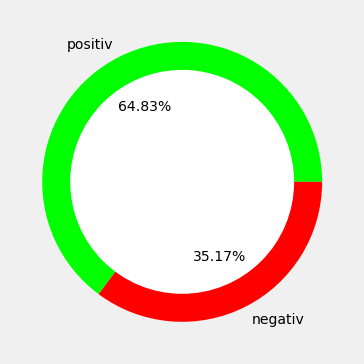

In [20]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.figure(figsize=(6, 6))
plt.pie(
    predict["sentiment"].value_counts(),
    autopct = "%.2f%%",
    labels = ["positiv", "negativ"],
    colors = ["#00ff00", "#ff0000"]
)

circle = plt.Circle((0,0), 0.80,fc='white')
fig = plt.gcf()
fig.gca().add_artist(circle)

plt.show()

In [21]:
text_negative_org = predict[predict["sentiment"]==0]
user = text_negative_org['user_name'].value_counts().nlargest(7)
pd.DataFrame(user)

,user_name
Detlef_2025,11
thescoborges,7
zater_barri,6
TelemundoNews,5
Mundo__News,4
capitalizo,3
luciaazevedo,3
